In [1]:
import numpy as np
import pandas as pd

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES']=""

In [3]:
import tensorflow as tf

In [4]:
import threading
import os
import cPickle as pickle
import logging
import pprint
import glob
import collections
import struct
import json
logging.basicConfig(format='%(asctime)s %(levelname)s: %(message)s', datefmt='%m/%d/%Y %I:%M:%S %p', level=logging.INFO)


In [5]:
logging.info('abc')

09/11/2017 08:49:41 PM INFO: abc


In [6]:
class GeneratorRunner(object):
    "Custom runner that that runs an generator in a thread and enqueues the outputs."

    def __init__(self, generator, placeholders, enqueue_op, close_op):
        self._generator = generator
        self._placeholders = placeholders
        self._enqueue_op = enqueue_op
        self._close_op = close_op

    def _run(self, sess, coord):
        try:
            while not coord.should_stop():
                try:
                    values = next(self._generator)

                    assert len(values) == len(self._placeholders), \
                        'generator values and placeholders must have the same length'

                    feed_dict = {placeholder: value \
                        for placeholder, value in zip(self._placeholders, values)}
                    sess.run(self._enqueue_op, feed_dict=feed_dict)
                except (StopIteration, tf.errors.OutOfRangeError, tf.errors.DeadlineExceededError, tf.errors.CancelledError) as e:
                    logging.warning ("%s %s %s", self.__class__.__name__, "exception:", str(type(e)))
                    try:
                        sess.run(self._close_op)
                    except Exception:
                        pass
                    return
        except Exception as ex:
            if coord:
                logging.info ("%s %s %s %s", self.__class__.__name__, "request stop from", self._run.__name__, str(ex))
                coord.request_stop(ex)
                pass
            else: 
                raise

    def create_threads(self, sess, coord=None, daemon=False, start=False):
        "Called by `start_queue_runners`."

        thread = threading.Thread(
            target=self._run,
            args=(sess, coord))

        if coord:
            coord.register_thread(thread)

        if daemon:
            thread.daemon = True

        if start:
            thread.start()

        return [thread]

def read_batch_generator(
        generator, dtypes, shapes, batch_size,
        queue_capacity=10000,
        allow_smaller_final_batch=False):
    "Reads values from an generator, queues, and batches."

    assert len(dtypes) == len(shapes), 'dtypes and shapes must have the same length'
    logging.info('shapes: %s, types: %s, batchsize: %d', str(shapes), str(dtypes), batch_size)
    queue = tf.FIFOQueue(
        capacity=queue_capacity,
        dtypes=dtypes,
        shapes=shapes)

    placeholders = [tf.placeholder(dtype, shape) for dtype, shape in zip(dtypes, shapes)]

    enqueue_op = queue.enqueue(placeholders)
    close_op = queue.close(cancel_pending_enqueues=True)
    global_close_ops.append(close_op)
    queue_runner = GeneratorRunner(generator, placeholders, enqueue_op, close_op)
    tf.train.add_queue_runner(queue_runner)

    if allow_smaller_final_batch:
        return queue.dequeue_up_to(batch_size)
    else:
        return queue.dequeue_many(batch_size)    

In [7]:
import random
import Queue
class MemoryGenerator(object):
    def __init__(self, daily_data,attrib_data, epochs=np.inf):
        self.daily_data = daily_data
        self.attrib_data = attrib_data        
        self.shuffle=True
        self.epochs = epochs
        self.N = len(self.daily_data)*10
        self.curr_epoch = 1
        self.curr_i = 0
        self.q = Queue.Queue()
        if self.shuffle:
            self.do_shuffle()
    def __iter__(self):
        return self
    def do_shuffle(self):
        idx = np.random.permutation(range(len(self.daily_data)))
        self.daily_data = self.daily_data[idx]     
        self.attrib_data = self.attrib_data[idx]
    def fill_queue(self):
        for _ in range(100):
            i=int(np.random.random()*len(self.daily_data))
            attrib_row=self.attrib_data[i]
            row=self.daily_data[i]
            len1=128
            len2=63
            j= random.randint(len1,len(row)-1)
            part_x=row[:j]
            x=row[j-len1:j]
                
            mad=np.median(x) 
            if mad==0: mad=1
            x=x/mad
            #x=np.append(x,np.log(mad))
            x=np.append(x,mad)

            part_y=row[j:j+len2]
            y=np.zeros(len2,dtype=np.float32)
            y[:len(part_y)]=part_y
            y=y/mad
            mask=np.zeros(len2,dtype=np.float32)
            mask[:len(part_y)]= (part_y!=0)*1
            self.q.put((x.astype(np.float32),attrib_row.astype(np.float32),np.array(y,dtype=np.float32),mask))
    def __next__(self):
        return self.next()
    def next(self):
        if self.curr_i >= self.N:
            self.curr_i = 0
            self.curr_epoch += 1
            if self.curr_epoch > self.epochs: raise StopIteration
            if self.shuffle: 
                self.do_shuffle()
        if self.q.empty(): self.fill_queue()
        X1,X2, y,mask = self.q.get()
        self.curr_i += 1
        return X1,X2, y,mask 


In [8]:
def make_train_readers(daily_data,attrib_data, nrows=None, batchsize=60):
    print daily_data.shape, attrib_data.shape
    train_generator = MemoryGenerator(daily_data,attrib_data)
    return read_batch_generator(train_generator, [tf.float32, tf.float32, tf.float32, tf.float32], 
                                [(128+1,), (12,), (63,),(63,)], batchsize, allow_smaller_final_batch=True),train_generator

In [9]:
locales=sorted([u'en', u'ja', u'de', u'fr', u'zh', u'ru', u'es'])
locale_map={v:u for u,v in enumerate(locales)}
locale_map

{u'de': 0, u'en': 1, u'es': 2, u'fr': 3, u'ja': 4, u'ru': 5, u'zh': 6}

In [10]:
access_map={u'all-access':0, u'mobile-web':1, u'desktop':2}
agent_map={u'all-agents':0, u'spider':1}
access_map,agent_map

({u'all-access': 0, u'desktop': 2, u'mobile-web': 1},
 {u'all-agents': 0, u'spider': 1})

In [11]:
def f_map(series, data_map):
    lst=[]
    keys=list(data_map.keys())
    for k in keys:
        lst.append(series.map(lambda u: (u==k)*1))
    df=pd.concat(lst,axis=1)
    df.columns=[series.name+"_"+u for u in keys]
    return df

In [12]:
def make_data(csv_path="../input/newtrain_2.csv"):
    import pandas as pd
    data = pd.read_csv(csv_path, nrows=None)
    datecols=[u for u in data.columns if u.startswith("20")]
    daily_data=data[datecols].values.astype(np.float32)
    attrib_data=pd.concat([f_map(data.locale,locale_map),
                           f_map(data.agent,agent_map),
                           f_map(data.access,access_map)],axis=1).values.astype(np.float32)    
    print daily_data.shape,attrib_data.shape
    return daily_data,attrib_data

In [12]:
daily_data,attrib_data=make_data()

(145063, 793) (145063, 12)


In [13]:
print np.mean(daily_data==0)
# daily_data += (daily_data==0)*0.1
# print np.mean(daily_data==0)

0.0742157607932


In [14]:
if 0:
    global_close_ops = []
    #daily_data,attrib_data=make_data()
    _, generator=make_train_readers(daily_data,attrib_data)
    a,b,c,d= generator.next()
    print a,b,c,d    
    print a.shape,b.shape,c.shape,d.shape


In [15]:
def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>" % size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    from IPython.display import clear_output, Image, display, HTML

    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph' + str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))


In [16]:
def weight_variable(shape, name):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial, name=name)

def bias_variable(shape, name):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial, name=name)

def dense(x, size, scope, with_activation=True):
    if 1:
        with tf.variable_scope(scope):
            w = weight_variable(shape=[int(x.get_shape()[-1]), size], name=None)
            b = bias_variable(shape=[size], name=None)
            h1 = tf.matmul(x, w) + b
            layer=tf.sigmoid(h1) if with_activation else h1
            print layer.get_shape()
    return layer,w,b
from tensorflow.contrib import rnn
def lstm(x,x2, n_hiddens, n_input, n_output, scope):
    if 1:
        with tf.variable_scope(scope):
            x = tf.reshape(x, [-1, n_input])
            x = tf.split(x,n_input,1)
            basic_rnn_cells = [rnn.BasicLSTMCell(n_hidden) for n_hidden in n_hiddens]
            rnn_cell = rnn.MultiRNNCell(basic_rnn_cells)
            outputs, states = rnn.static_rnn(rnn_cell, x, dtype=tf.float32) 
            concat_x=tf.concat([outputs[-1],x2],-1)
            print outputs[-1].get_shape(), concat_x.get_shape()             
            return concat_x

def get_Xy(x_size,x2_size,y_size):
    X = tf.placeholder("float", shape=[None, x_size], name='input_x')
    X2 = tf.placeholder("float", shape=[None, x2_size], name='input_x2')    
    l2_scale = tf.placeholder(tf.float32, name='l2_scale')
    y = tf.placeholder("float", shape=[None, y_size], name='input_y')
    mask = tf.placeholder("float", shape=[None, y_size], name='mask')
    return X,X2, y,mask, l2_scale

In [17]:
class MyModel(object):
    def __init__(self, x_size,y_size, n_hiddens,l2_scale,phase=True ):
        self.phase=phase
        n_hiddens=n_hiddens
        self.graph = tf.Graph()
        self.all_denses = []
        with self.graph.as_default(): 
            self.X, self.X2, self.y, self.mask, self.l2_scale = get_Xy(x_size,12, y_size)
            assert(x_size == self.X.get_shape()[1])
            with tf.variable_scope("nodes"):
                self.X, self.y, self.loss, self.smape \
                     = self.make_model(x_size=x_size, y_size=y_size, n_hiddens=n_hiddens)

            
            with tf.variable_scope('saver'):
                    self.saver = tf.train.Saver()

            update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
            with tf.variable_scope('optimizer'):
                with tf.control_dependencies(update_ops):
                    self.optimizer = tf.train.AdamOptimizer()#.minimize(self.loss)
                    gvs = self.optimizer.compute_gradients(self.loss)
                    capped_gvs = [(tf.clip_by_value(grad, -1., 1.), var) for grad, var in gvs]
                    self.train_op = self.optimizer.apply_gradients(capped_gvs)
        self._session = None    
    @property
    def session(self): 
        if self._session is None:
            config = tf.ConfigProto(log_device_placement=True)
            config.gpu_options.per_process_gpu_memory_fraction = 0.5  # don't hog all vRAM
            self._session = tf.Session(graph=self.graph,config=config)
        return self._session
    
    def close_session(self):
        if self._session is not None:
            self._session.close()
            self._session = None
    def initialize(self, session=None):
        with self.graph.as_default():
            init_op = tf.global_variables_initializer()        
        self.session.run(init_op) 
        return self.session
 
        
    def make_model(self, x_size,y_size, n_hiddens):
        X_raw, y  = self.X, self.y 
        logging.debug ("%s %s", self.__class__.__name__,
                       'input shapes: X={},y={}'.format(X_raw.get_shape(), None if y is None else y.get_shape()))

        h = tf.log(X_raw+1)
        #h=X_raw
        #h=     tf.layers.batch_normalization(h,center=False, scale=True,training=self.phase)
        
        h=lstm(h,self.X2, [n_hiddens[0]], x_size, y_size, 'lstm')
        for i in range(0, len(n_hiddens)):
            n_hidden = n_hiddens[i]
            h, w,b = dense(h, n_hidden,'dense')
            self.all_denses.append((h,w,b))

        logits_sum,_,_=dense(h,y_size,'dense',with_activation=False)
        
        with tf.variable_scope("loss"):
            epsilon = 1e-7        
            l2_loss = 0
            if 1:  # self.l2_scale > 0:
                logging.info('use l2 reg scale %s', str(self.l2_scale))
                for _,w,_ in self.all_denses:
                    l2_loss = l2_loss + tf.reduce_sum(w ** 2)
                l2_loss = l2_loss * self.l2_scale
                self.l2_loss = l2_loss
            if 1:
                predictions = tf.identity(logits_sum, name='prediction')
                float_labels = tf.cast(y, tf.float32)

                ratio=predictions/(float_labels+1e-4)
                additional_loss= 0.02*tf.cast(ratio>9,tf.float32)*tf.abs(ratio)\
                    +0.02*tf.cast(predictions<0.0,tf.float32)*tf.abs(predictions)
                additional_loss = tf.reduce_sum(additional_loss*self.mask)/tf.reduce_sum(self.mask)
                
                this_loss =  tf.abs(predictions-float_labels)/(tf.abs(predictions)+tf.abs(float_labels)+1e-7)
                this_loss=this_loss*self.mask
                this_loss = tf.identity(2* tf.reduce_sum(this_loss)/tf.reduce_sum(self.mask), name='smape')                          
                loss = this_loss + l2_loss+additional_loss

            logging.info ('%s %s %s', self.__class__.__name__, 'logits shape', logits_sum.get_shape())

        return X_raw, y, loss, this_loss
 
    
    def save(self, prefix, ckpt=1):
        checkpoint_name = '{}/model_{}'.format(prefix, 0)
        self.saver.save(self.session, checkpoint_name, global_step=ckpt)

    def load(self, prefix, ckpt=1):
        self.saver.restore(self.session, '{}/model_{}-{}'.format(prefix, self.model_id, ckpt))


In [18]:
if 0:
    tf.reset_default_graph()
    model = MyModel(x_size=5, y_size=2, n_hiddens=[2,2], l2_scale=0.1)
    model.initialize()
    #print [n.op for n in model.graph.as_graph_def().node];
    show_graph(model.graph.as_graph_def())

In [19]:
def svd_orthonormal(shape):
    print(shape)
    if len(shape) < 2:
        raise RuntimeError("Only shapes of length 2 or more are supported.")
    flat_shape = (shape[0], np.prod(shape[1:]))
    a = np.random.standard_normal(flat_shape)
    u, _, v = np.linalg.svd(a, full_matrices=False)
    q = u if u.shape == flat_shape else v
    q = q.reshape(shape)
    return q

def get_activations(model, h, X_batch):
    activations = model.session.run(h, feed_dict={model.X:X_batch})
    return activations

def LSUVinit(model, batch):
    # only these layer classes considered for LSUV initialization; add more if needed    
    margin = 0.1
    max_iter = 10
    layers_inintialized = 0
    for h,w,_ in model.all_denses:
        # avoid small layers where activation variance close to zero, esp. for small batches
        if np.prod(h.get_shape()) < 32:
            print(h, 'too small')
            continue
        logging.info('LSUV initializing' + str(h))
        layers_inintialized += 1
        needed_variance = 1.0
        
        # print ('pre',np.sum(model.session.run(np.abs(w))))
        weights = svd_orthonormal(w.get_shape())
        model.session.run(tf.assign(w, weights))
        # print (model.session.run(w),weights)
        # print ('post',np.sum(model.session.run(np.abs(w))),np.sum(np.abs(weights)))        
        acts1 = get_activations(model, h, batch)
        # print (acts1,needed_variance)
        
        var1 = np.var(acts1)
        iter1 = 0
        logging.info('var1 %f', var1)
        while (abs(needed_variance - var1) > margin):
            if np.abs(np.sqrt(var1)) < 1e-7: break  # avoid zero division
            weights /= np.sqrt(var1) / np.sqrt(needed_variance)
            model.session.run(tf.assign(w, weights))
            acts1 = get_activations(model, h, batch)
            var1 = np.var(acts1)
            iter1 += 1
            # print (acts1)
            logging.info('var1 %f', var1)
            if iter1 > max_iter:
                break
    logging.info('LSUV: total layers initialized %d', layers_inintialized)   
    return model


In [20]:

class BN(object):
    def __init__(self, x_size, y_size, n_hiddens, l2_scale=0.0, prefix='./tmp'):
        self.x_size = x_size
        self.y_size=y_size
        self.n_hiddens = n_hiddens
        self.l2_scale = l2_scale
        self.prefix = prefix
    

    def train_one_epoch(self, n_epoch, sess, model, train_reader,test_reader, coord):
        count = 0
        loss = []; l2_loss = []
        while not coord.should_stop():
            try:
                if  True:
                    X,X2, y,mask = sess.run(train_reader)
                    feed_dict = {model.X:X, model.X2:X2, model.y:y, model.mask:mask, model.l2_scale: self.l2_scale}
                    _, a, aa = model.session.run([model.train_op, model.loss, model.l2_loss], 
                                                    feed_dict=feed_dict)
                    loss.append(a)
                    l2_loss.append(aa)
                    count += len(y)
                    if count % self.net_train_report_intev == 0:

                        logging.info ('[epoch {}][step {}] AVG LOSS: {}, L2LOSS: {}'.format(
                            n_epoch, count, np.mean(loss), np.mean(l2_loss)))
                        loss = []; l2_loss = []
                        #self.read_params()

                    if count >= self.net_train_eval_intev:
                        X,X2, y,mask = sess.run(test_reader)
                        feed_dict = {model.X:X, model.X2:X2, model.y:y, model.mask:mask, model.l2_scale: self.l2_scale}
                        a, aa = model.session.run([ model.loss, model.smape], 
                                                    feed_dict=feed_dict)
                        logging.info ('[epoch {}] Valid LOSS: {}, smape: {}'.format(
                            n_epoch, a, aa))                        
                        return 0
            except tf.errors.OutOfRangeError:
                logging.info (self.__class__.__name__, 'Done with read')
                logging.info (self.__class__.__name__, "request stop from", self.train_one_epoch.__name__)                
                coord.request_stop()
                for o in global_close_ops: sess.run(o)
                return 1                                      
            except:
                raise           
        return 0


    def save_net(self, sess, model, n_epoch):
        model.save(prefix=self.prefix, ckpt=n_epoch)

    def train(self, daily_data,attrib_data, net_round,net_train_report_intev,net_train_eval_intev):
        self.net_train_report_intev=net_train_report_intev
        self.net_train_eval_intev=net_train_eval_intev
        model = MyModel(x_size=self.x_size, y_size=self.y_size, n_hiddens=self.n_hiddens,
                             l2_scale=self.l2_scale)
        model.initialize()
        config = tf.ConfigProto(log_device_placement=True)
        config.gpu_options.per_process_gpu_memory_fraction = 0.5  # don't hog all vRAM
        # config.operation_timeout_in_ms = 10000  # terminate on long hangs
        idx=np.random.permutation(range(len(daily_data)))
        trainidx=idx[:int(len(idx)*0.8)]
        testidx=idx[int(len(idx)*0.8):]
        train_daily_data=daily_data[trainidx]
        train_attrib_data=attrib_data[trainidx]
        test_daily_data=daily_data[testidx]
        test_attrib_data=attrib_data[testidx] 
        print train_daily_data.shape,test_daily_data.shape
        with tf.Session(config=config) as sess:
            train_reader,_ = make_train_readers(train_daily_data,train_attrib_data,batchsize=batch_size,nrows=None)            
            test_reader,_ = make_train_readers(test_daily_data,test_attrib_data,batchsize=batch_size*20,nrows=None)            
            coord = tf.train.Coordinator()
            threads = tf.train.start_queue_runners(sess=sess, coord=coord)
            res = None
            try:
                if 0:
                    logging.info('Use LSUV initialization')
                    batch = np.concatenate([sess.run(train_reader)[0] for _ in range(100)])
                    LSUVinit(model, batch)
                for j in range(net_round):
                    logging.info ('[epoch {}] start net training'.format(j))
                    if self.train_one_epoch(j, sess, model, train_reader,test_reader, coord) is None:
                        raise Exception("train error")
                    self.save_net(sess=sess, model=model, n_epoch=0)
            except:
                raise 
            finally:
                logging.info ('%s %s %s', self.__class__.__name__, "request stop from", self.train.__name__)
                for o in global_close_ops: sess.run(o)                
                coord.request_stop()

            coord.join(threads)
            sess.close()
            model.close_session()
            return 

    def read_params(self):
	try:
	    with open('param.txt') as f:
	        m = json.load(f)
 	    a = m["l2_scale"]
	    if self.l2_scale != a: 
		logging.info("Change l2_scale from %e to %e", self.l2_scale, a)
	     	self.l2_scale = a
	except:
	    logging.error('read params failed')


In [21]:
daily_data.shape

(145063, 793)

In [22]:
l2_scale = 1e-8*0

batch_size = 256

if 0: #test
    n_hiddens=[10]
    net_round=10
    net_train_report_intev=batch_size*10
    net_train_eval_intev=10000
else:
    n_hiddens=[512,512]    
    net_round=200
    net_train_report_intev=batch_size*100
    net_train_eval_intev=batch_size*1000

In [23]:
global_close_ops = []
tf.reset_default_graph()       
model = BN(x_size=128+1, y_size=63, n_hiddens=n_hiddens, prefix='tmp_pred60_lstm_512_medadj_nozero_noxpad', l2_scale=l2_scale)
model.train(daily_data,attrib_data,  \
           net_round=net_round,  net_train_report_intev=net_train_report_intev,
            net_train_eval_intev=net_train_eval_intev )  

09/09/2017 12:52:21 AM INFO: use l2 reg scale Tensor("l2_scale:0", dtype=float32)
09/09/2017 12:52:21 AM INFO: MyModel logits shape (?, 63)


(?, 512) (?, 524)
(?, 512)
(?, 512)
(?, 63)
(116050, 793) (29013, 793)
(116050, 793) (116050, 12)


09/09/2017 12:52:40 AM INFO: shapes: [(129,), (12,), (63,), (63,)], types: [tf.float32, tf.float32, tf.float32, tf.float32], batchsize: 256
09/09/2017 12:52:40 AM INFO: shapes: [(129,), (12,), (63,), (63,)], types: [tf.float32, tf.float32, tf.float32, tf.float32], batchsize: 5120
09/09/2017 12:52:40 AM INFO: [epoch 0] start net training


(29013, 793) (29013, 12)


09/09/2017 12:53:09 AM INFO: [epoch 0][step 25600] AVG LOSS: 0.547479808331, L2LOSS: 0.0
09/09/2017 12:53:31 AM INFO: [epoch 0][step 51200] AVG LOSS: 0.473774254322, L2LOSS: 0.0
09/09/2017 12:53:52 AM INFO: [epoch 0][step 76800] AVG LOSS: 0.47350075841, L2LOSS: 0.0
09/09/2017 12:54:14 AM INFO: [epoch 0][step 102400] AVG LOSS: 0.470823675394, L2LOSS: 0.0
09/09/2017 12:54:36 AM INFO: [epoch 0][step 128000] AVG LOSS: 0.460784614086, L2LOSS: 0.0
09/09/2017 12:54:57 AM INFO: [epoch 0][step 153600] AVG LOSS: 0.449211150408, L2LOSS: 0.0
09/09/2017 12:55:19 AM INFO: [epoch 0][step 179200] AVG LOSS: 0.439668059349, L2LOSS: 0.0
09/09/2017 12:55:41 AM INFO: [epoch 0][step 204800] AVG LOSS: 0.432562440634, L2LOSS: 0.0
09/09/2017 12:56:02 AM INFO: [epoch 0][step 230400] AVG LOSS: 0.430428624153, L2LOSS: 0.0
09/09/2017 12:56:24 AM INFO: [epoch 0][step 256000] AVG LOSS: 0.428020477295, L2LOSS: 0.0
09/09/2017 12:56:25 AM INFO: [epoch 0] Valid LOSS: 0.431610792875, smape: 0.430207580328
09/09/2017 12:5

# Check

In [14]:
sess=tf.Session()

In [13]:
saver = tf.train.import_meta_graph('tmp_pred60_lstm_512_medadj_nozero_noxpad/model_0-0.meta')

In [15]:
saver.restore(sess,tf.train.latest_checkpoint('tmp_pred60_lstm_512_medadj_nozero_noxpad/'))

INFO:tensorflow:Restoring parameters from tmp_pred60_lstm_512_medadj_nozero_noxpad/model_0-0


09/11/2017 08:50:01 PM INFO: Restoring parameters from tmp_pred60_lstm_512_medadj_nozero_noxpad/model_0-0


In [16]:
graph = tf.get_default_graph()

In [17]:
x = graph.get_tensor_by_name("input_x:0")
x2 = graph.get_tensor_by_name("input_x2:0")
l2_scale = graph.get_tensor_by_name("l2_scale:0")
y = graph.get_tensor_by_name("input_y:0")
m=graph.get_tensor_by_name("mask:0")
prediction=graph.get_tensor_by_name("nodes/loss/prediction:0")
loss=graph.get_tensor_by_name('nodes/loss/smape:0')

In [29]:
X=[];X2=[];Y=[];MASK=[]
for _ in range(10000):
    i=int(np.random.random()*len(daily_data))
    attrib_row=attrib_data[i]
    row=daily_data[i]
    len1=128
    len2=63
    j=int(np.random.random()*(len(row)-1))
    part_x=row[:j]
    if len(part_x)>=len1:
        xx=part_x[len(part_x)-len1:]
    else:
        xx=np.zeros(len1,dtype=np.float32)
        xx[len1-len(part_x):]=part_x

    mad=np.median(xx) 
    if mad==0: mad=1
    xx=xx/mad
    xx=np.append(xx,(mad))

    part_y=row[j:j+len2]
    yy=np.zeros(len2,dtype=np.float32)
    yy[:len(part_y)]=part_y
    yy=yy/mad
    mask=np.zeros(len2,dtype=np.float32)
    #mask[:len(part_y)]=1
    mask[:len(part_y)]=part_y>0           
    a,aa,b,c= xx.astype(np.float32),attrib_row.astype(np.float32),np.array(yy,dtype=np.float32),mask
    X.append(a),X2.append(aa),Y.append(b),MASK.append(c)

In [30]:
X=np.array(X);X2=np.array(X2);Y=np.array(Y);MASK=np.array(MASK)
X.shape,X2.shape,Y.shape,MASK.shape

((10000, 129), (10000, 12), (10000, 63), (10000, 63))

In [31]:
feed_dict={x:X,x2:X2, y:Y,m:MASK,l2_scale:0}

In [32]:
sess.run(loss,feed_dict=feed_dict)

0.37674099

In [33]:
a=sess.run(prediction,feed_dict=feed_dict)
a=np.abs(a)#-1
print a.shape

(10000, 63)


In [34]:
np.isnan(a).sum()

0

In [35]:
len(set(np.where(np.isnan(a))[0]))

0

In [36]:
a.max(),a.min()

(2038.9774, 1.1235476e-05)

In [37]:
this_loss =  2*np.abs(a-Y)/(np.abs(a)+np.abs(Y))
print np.sum(this_loss<=0),np.mean(this_loss==2),np.mean((Y==0) & (mask!=0))
this_loss=this_loss*MASK
print this_loss.sum()
this_loss.sum()/MASK.sum() 

0 0.105631746032 0.105631746032
212267.0


0.37672585

In [38]:
MASK.sum()

563452.0

In [39]:
lst=[]
for i in range(1000):
    u=Y[i]
    v=a[i]
    t=MASK[i]
    lst.append(((2*np.abs(u-v)/(np.abs(u)+np.abs(v)))).mean())
    #lst.append(((2*np.abs(v-u)/(np.abs(u)+np.abs(v)))*t).sum()  )  
lst=np.array(lst)
print np.sum(lst),lst.shape,np.mean(lst[lst<2]),np.mean(lst)    

536.32 (1000,) 0.48166 0.53632


Populating the interactive namespace from numpy and matplotlib


/home/bo/anaconda2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


0.53632


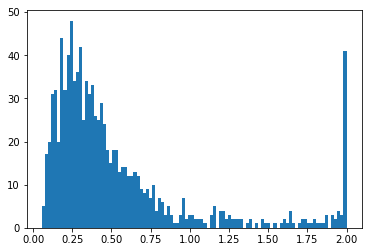

In [40]:
%pylab inline
plt.hist(lst,bins=100);
print np.mean(lst) 

0.665111 0.735486 0.141482


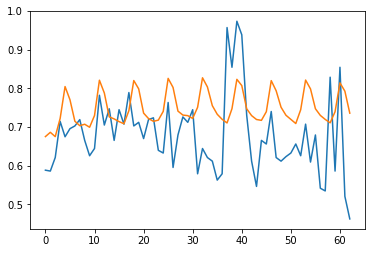

In [41]:
i=int(np.random.random()*1000)
u=Y[i][:63]
v=a[i]
plt.plot(u)
plt.plot(v)
print np.median(u),np.median(v), (2*np.abs(u-v)/(np.abs(u)+np.abs(v))).mean()

# predict

In [18]:
daily_data,attrib_data=make_data("../input/newtrain_3.csv")

(145063, 803) (145063, 12)


In [19]:
daily_data.shape,attrib_data.shape

((145063, 803), (145063, 12))

In [20]:
X1=daily_data[:,-128:]
mad=np.median(X1,1) 
mad[mad==0]=1.0
X1=np.concatenate([X1/mad.reshape(-1,1),mad.reshape(-1,1)],axis=1)
attrib_test=attrib_data
X1.shape,attrib_test.shape

((145063, 129), (145063, 12))

In [21]:
feed_dict={x:X1,x2:attrib_test}
predTest=sess.run(prediction,feed_dict=feed_dict)
predTest.shape

(145063, 63)

In [22]:
mad.shape

(145063,)

In [23]:
predTest=predTest*mad.reshape(-1,1)

In [24]:
predTest=np.round(predTest,1)
np.mean(predTest<0.001)

8.8631441905536617e-06

In [26]:
import datetime
cols=pd.date_range(pd.datetime.date(datetime.datetime(2017, 9, 13)), periods=62).map(lambda u: u.strftime("%Y-%m-%d"))
idx=pd.read_csv("../input/train_3.csv",usecols=[0])["Page"]
idx.shape

(145063,)

In [27]:
len(cols),predTest.shape

(62, (145063, 63))

In [28]:
tmp=predTest
print "Assume predicting from 9/11 to 11/12, but it requires from 9/13 to 11/13"
predTest=predTest[:,-61:]
assert (predTest.shape[1]==61)
predTest=np.concatenate([predTest,predTest[:,[-1]]],axis=1)
assert (predTest.shape[1]==62)

Assume predicting from 9/11 to 11/12, but it requires from 9/13 to 11/13


In [29]:
submission=pd.DataFrame(predTest,columns=cols,index=idx)
submission=submission.unstack().reset_index()
submission['name']=submission.apply(lambda r: "{}_{}".format(r['Page'],r['level_0']),axis=1)
submission=submission.drop(['Page','level_0'],axis=1)
submission.columns=['Visits','name']

In [30]:
submission=submission[["name",'Visits']]
submission.head()

name     Visits
0  2NE1_zh.wikipedia.org_all-access_spider_2017-0...  26.600000
1  2PM_zh.wikipedia.org_all-access_spider_2017-09-13  22.299999
2   3C_zh.wikipedia.org_all-access_spider_2017-09-13   5.200000
3  4minute_zh.wikipedia.org_all-access_spider_201...  14.800000
4  52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...  14.300000

In [31]:
keys=pd.read_csv("../input/key_2.csv",index_col=0)

In [32]:
keys_dict=keys["Id"].to_dict()

In [33]:
submission["Id"]=submission["name"].apply(lambda u:keys_dict[u])

In [34]:
submission.isnull().sum().sum()

0

In [35]:
submission.head()

name     Visits            Id
0  2NE1_zh.wikipedia.org_all-access_spider_2017-0...  26.600000  4ba4d551a031
1  2PM_zh.wikipedia.org_all-access_spider_2017-09-13  22.299999  60d27ad56a15
2   3C_zh.wikipedia.org_all-access_spider_2017-09-13   5.200000  fd318ba35812
3  4minute_zh.wikipedia.org_all-access_spider_201...  14.800000  6f94c9eff16b
4  52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...  14.300000  3d831f757952

In [36]:
submission[["Id","Visits"]].to_csv("../submission/sub2_pred_lstm1_60_medadj_nozero_noxpad.csv.gz",
                                   index=None, float_format='%.1f', compression="gzip")